In [1]:
import tensorflow as tf
import keras
from keras.applications import MobileNetV3Large
from keras.applications.mobilenet_v3 import preprocess_input,decode_predictions
from keras.layers import Dense,BatchNormalization,Dropout,GlobalAveragePooling2D
from keras.callbacks import EarlyStopping
import mlflow

2025-02-24 12:34:40.895296: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-24 12:34:41.038318: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740380681.070106  619455 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740380681.082217  619455 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-24 12:34:41.196307: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

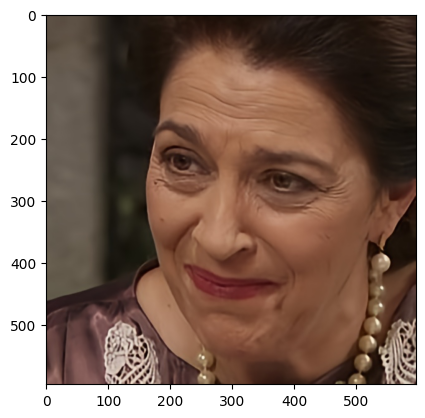

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread("affectnet/confident/image0022879.jpg")
plt.imshow(img)

In [3]:
type(img)

numpy.ndarray

In [4]:
import numpy as np
img=np.expand_dims(img,axis=0)

In [5]:
model=MobileNetV3Large(weights="imagenet")

/home/rijo/.local/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(
2025-02-24 12:34:46.119696: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [6]:
prd=model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 788ms/step


In [7]:
decode_predictions(prd)

[[('n03838899', 'oboe', 0.028886741),
  ('n03724870', 'mask', 0.028320674),
  ('n03372029', 'flute', 0.021115962),
  ('n02892767', 'brassiere', 0.017167956),
  ('n03676483', 'lipstick', 0.017031811)]]

In [8]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input, 
                                   rotation_range=15,
                                   height_shift_range=0.2, 
                                   width_shift_range=0.2, 
                                   fill_mode='nearest', 
                                   zoom_range=0.1)

train = train_datagen.flow_from_directory(
    directory="affectnet/", 
    target_size=(224, 224),  
    batch_size=32,
    class_mode="sparse",  
    shuffle=True
)


Found 15221 images belonging to 3 classes.


In [9]:
base_model=MobileNetV3Large(weights="imagenet", include_top=False)

In [10]:
for layer in base_model.layers:
    layer.trainable=False

In [11]:
x=GlobalAveragePooling2D()(base_model.output)
x=Dense(256,activation="relu")(x)
x=BatchNormalization()(x)
x=Dropout(0.3)(x)
x=Dense(128,activation="relu")(x)
x=Dropout(0.2)(x)
output=Dense(3)(x)

In [12]:
model=keras.Model(inputs=base_model.input,outputs=output)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, None,      │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv (Conv2D)       │ (None, None,      │        432 │ rescaling_1[0][0] │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_bn             │ (None, None,      │         64 │ conv[0][0]        │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, None,      │          0 │ conv_bn[0][0]     │
│ (Activation)        │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │        144 │ activation_21[0]… │
│ (DepthwiseConv2D)   │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, None,      │         64 │ expanded_conv_de… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_19 (ReLU)     │ (None, None,      │          0 │ expanded_conv_de… │
│                     │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │        256 │ re_lu_19[0][0]    │
│ (Conv2D)            │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, None,      │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ None, 16)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_add   │ (None, None,      │          0 │ activation_21[0]… │
│ (Add)               │ None, 16)         │            │ expanded_conv_pr… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, None,      │      1,024 │ expanded_conv_ad… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_ex… │ (None, None,      │        256 │ expanded_conv_1_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_20 (ReLU)     │ (None, None,      │          0 │ expanded_conv_1_… │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, None,      │          0 │ re_lu_20[0][0]    │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, None,      │        576 │ expanded_conv_1_… │
│ (DepthwiseConv2D)   │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_1_de… │ (None, None,      │        256 │ expanded_conv_1_

 Total params: 3,276,675 (12.50 MB)

 Trainable params: 279,811 (1.07 MB)

 Non-trainable params: 2,996,864 (11.43 MB)

In [14]:
early=EarlyStopping(patience=2, 
                    restore_best_weights=True,
                      monitor="loss",)

In [15]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [16]:
model.fit(train,epochs=10,callbacks=[early])

/home/rijo/.local/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 281s 583ms/step - accuracy: 0.6413 - loss: 0.8683
Epoch 2/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 278s 583ms/step - accuracy: 0.7555 - loss: 0.5811
Epoch 3/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 277s 583ms/step - accuracy: 0.7786 - loss: 0.5383
Epoch 4/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 279s 585ms/step - accuracy: 0.7858 - loss: 0.5188
Epoch 5/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 335s 705ms/step - accuracy: 0.7944 - loss: 0.4996
Epoch 6/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 278s 584ms/step - accuracy: 0.8002 - loss: 0.4896
Epoch 7/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 282s 591ms/step - accuracy: 0.8010 - loss: 0.4910
Epoch 8/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 281s 591ms/step - accuracy: 0.7972 - loss: 0.4893
Epoch 9/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 284s 597ms/step - accuracy: 0.8032 - loss: 0.4799
Epoch 10/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 282s 592ms/step - accuracy: 0.8069 - loss: 0.4739


In [17]:
train.class_indices

{'confident': 0, 'focused': 1, 'scared': 2}

In [18]:
img=mpimg.imread("test_image/scared.jpeg")

In [19]:
img=preprocess_input(img)
img=np.expand_dims(img,axis=0)

In [20]:
prediction=model.predict(img)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step


In [21]:
np.argmax(prediction)

2

In [22]:
import dagshub
dagshub.init(repo_owner='slalrijo2005', repo_name='Quizzy', mlflow=True)

Accessing as slalrijo2005

Initialized MLflow to track repo "slalrijo2005/Quizzy"

Repository slalrijo2005/Quizzy initialized!

In [23]:
mlflow.set_experiment("emotion_detection_model")
mlflow.set_registry_uri("https://dagshub.com/slalrijo2005/Quizzy.mlflow")

In [24]:
with mlflow.start_run(run_name="mobilenet_v3"): 
      mlflow.log_params(model.optimizer.get_config())
      mlflow.log_metrics({"accuracy": 0.8425,"loss":0.3746})
      mlflow.tensorflow.log_model(model,"mobilenet_model")

2025/02/24 13:22:31 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/02/24 13:22:41 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run mobilenet_v3 at: https://dagshub.com/slalrijo2005/Quizzy.mlflow/#/experiments/0/runs/fa0ef67d85574b559536f8bdb70505d5
🧪 View experiment at: https://dagshub.com/slalrijo2005/Quizzy.mlflow/#/experiments/0


In [26]:
model_id="fa0ef67d85574b559536f8bdb70505d5"
model_name="mobilenet_model"
result = mlflow.register_model(
    f"runs:/{model_id}/{model_name}", "mobilenet_model"
)

Registered model 'mobilenet_model' already exists. Creating a new version of this model...
2025/02/24 13:23:44 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: mobilenet_model, version 4
Created version '4' of model 'mobilenet_model'.
